In [2]:
!pip install tensorflow pillow scikit-learn kaggle -q
print("✅ Dependencies installed!")


✅ Dependencies installed!


In [5]:
from google.colab import files

print("📤 Upload your kaggle.json file")
print("Go to: https://www.kaggle.com/settings/account → Create New API Token")
print("\nWaiting for file upload...\n")

uploaded = files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n✅ Kaggle API configured!")


📤 Upload your kaggle.json file
Go to: https://www.kaggle.com/settings/account → Create New API Token

Waiting for file upload...



Saving kaggle.json to kaggle.json

✅ Kaggle API configured!


In [6]:
import os
os.chdir('/content')

print("⏳ Downloading dataset from Kaggle...")
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -q

print("⏳ Extracting...")
!unzip -q chest-xray-pneumonia.zip

print("✅ Dataset ready!")
!ls -la chest_xray/


⏳ Downloading dataset from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
⏳ Extracting...
✅ Dataset ready!
total 28
drwxr-xr-x 7 root root 4096 Nov 17 17:31 .
drwxr-xr-x 1 root root 4096 Nov 17 17:31 ..
drwxr-xr-x 5 root root 4096 Nov 17 17:31 chest_xray
drwxr-xr-x 3 root root 4096 Nov 17 17:31 __MACOSX
drwxr-xr-x 4 root root 4096 Nov 17 17:31 test
drwxr-xr-x 4 root root 4096 Nov 17 17:31 train
drwxr-xr-x 4 root root 4096 Nov 17 17:31 val


In [7]:
# ========== CELL 3: Training Script (SAME AS BEFORE) ==========
"""
Pneumonia Detection Model Training - COMPLETE COLAB VERSION
"""

import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Functions
def load_config():
    return {
        'preprocessing': {'target_size': [224, 224]},
        'augmentation': {
            'rotation_range': 20,
            'horizontal_flip': True,
            'zoom_range': 0.2,
            'width_shift_range': 0.1,
            'height_shift_range': 0.1
        },
        'training': {
            'batch_size': 32,
            'epochs': 50,
            'early_stopping': {'patience': 5}
        }
    }

def build_vgg16_model():
    logger.info("Building VGG16...")
    base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
    return model

def create_data_generators(config):
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True,
                                      zoom_range=0.2, width_shift_range=0.1, height_shift_range=0.1)
    val_datagen = ImageDataGenerator(rescale=1./255)
    return train_datagen, val_datagen

def train_model(train_dir, val_dir, model, datagen, config):
    train_datagen, val_datagen = datagen

    train_gen = train_datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                                 batch_size=32, class_mode='binary', shuffle=True)
    val_gen = val_datagen.flow_from_directory(val_dir, target_size=(224, 224),
                                             batch_size=32, class_mode='binary', shuffle=False)

    callbacks = [
        EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True, mode='max'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
        ModelCheckpoint('/content/models/vgg16_best.h5', monitor='val_recall', save_best_only=True, mode='max')
    ]

    history = model.fit(train_gen, epochs=config['training']['epochs'], validation_data=val_gen,
                       callbacks=callbacks, verbose=1)
    return history

# Configuration
TRAIN_DIR = '/content/chest_xray/train'
VAL_DIR = '/content/chest_xray/val'
os.makedirs('/content/models', exist_ok=True)

config = load_config()
model = build_vgg16_model()
model.summary()

datagen = create_data_generators(config)
print("\n🚀 Starting training...\n")
history = train_model(TRAIN_DIR, VAL_DIR, model, datagen, config)

model.save('/content/models/vgg16_final.h5')
print("\n✅ TRAINING COMPLETED!")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,108,929 (57.64 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


🚀 Starting training...

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.7079 - loss: 0.5765 - precision_1: 0.7446 - recall_1: 0.9187

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: accuracy,loss,precision_1,recall_1,val_accuracy,val_loss,val_precision_1,val_recall_1
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_recall available.
  if self._should_save_model(epoch, batch, logs, filepath):


163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 709ms/step - accuracy: 0.7082 - loss: 0.5761 - precision_1: 0.7447 - recall_1: 0.9190 - val_accuracy: 0.5625 - val_loss: 0.6417 - val_precision_1: 0.5333 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8181 - loss: 0.3795 - precision_1: 0.8366 - recall_1: 0.9410

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 643ms/step - accuracy: 0.8182 - loss: 0.3793 - precision_1: 0.8367 - recall_1: 0.9409 - val_accuracy: 0.7500 - val_loss: 0.6225 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8777 - loss: 0.2883 - precision_1: 0.9044 - recall_1: 0.9327

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 642ms/step - accuracy: 0.8777 - loss: 0.2882 - precision_1: 0.9044 - recall_1: 0.9327 - val_accuracy: 0.7500 - val_loss: 0.7137 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.8934 - loss: 0.2575 - precision_1: 0.9247 - recall_1: 0.9321

163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 639ms/step - accuracy: 0.8934 - loss: 0.2574 - precision_1: 0.9247 - recall_1: 0.9321 - val_accuracy: 0.7500 - val_loss: 0.5796 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.8924 - loss: 0.2511 - precision_1: 0.9282 - recall_1: 0.9263

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 642ms/step - accuracy: 0.8924 - loss: 0.2510 - precision_1: 0.9282 - recall_1: 0.9263 - val_accuracy: 0.7500 - val_loss: 0.5729 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9058 - loss: 0.2196 - precision_1: 0.9348 - recall_1: 0.9373

163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 639ms/step - accuracy: 0.9058 - loss: 0.2196 - precision_1: 0.9348 - recall_1: 0.9373 - val_accuracy: 0.7500 - val_loss: 0.5932 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9106 - loss: 0.2164 - precision_1: 0.9390 - recall_1: 0.9419

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 642ms/step - accuracy: 0.9106 - loss: 0.2164 - precision_1: 0.9390 - recall_1: 0.9419 - val_accuracy: 0.7500 - val_loss: 0.7386 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9100 - loss: 0.2194 - precision_1: 0.9433 - recall_1: 0.9336

163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 640ms/step - accuracy: 0.9100 - loss: 0.2193 - precision_1: 0.9433 - recall_1: 0.9337 - val_accuracy: 0.7500 - val_loss: 0.4955 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9174 - loss: 0.1961 - precision_1: 0.9478 - recall_1: 0.9397

163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 640ms/step - accuracy: 0.9174 - loss: 0.1961 - precision_1: 0.9478 - recall_1: 0.9397 - val_accuracy: 0.7500 - val_loss: 0.5092 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9276 - loss: 0.1901 - precision_1: 0.9538 - recall_1: 0.9478

163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 638ms/step - accuracy: 0.9276 - loss: 0.1901 - precision_1: 0.9538 - recall_1: 0.9479 - val_accuracy: 0.7500 - val_loss: 0.5351 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9338 - loss: 0.1769 - precision_1: 0.9595 - recall_1: 0.9500

163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 639ms/step - accuracy: 0.9338 - loss: 0.1770 - precision_1: 0.9595 - recall_1: 0.9501 - val_accuracy: 0.7500 - val_loss: 0.5708 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 12/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9240 - loss: 0.1817 - precision_1: 0.9504 - recall_1: 0.9458

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 645ms/step - accuracy: 0.9241 - loss: 0.1817 - precision_1: 0.9504 - recall_1: 0.9458 - val_accuracy: 0.7500 - val_loss: 0.6022 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 5.0000e-05
Epoch 13/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9287 - loss: 0.1767 - precision_1: 0.9494 - recall_1: 0.9564

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 643ms/step - accuracy: 0.9287 - loss: 0.1767 - precision_1: 0.9494 - recall_1: 0.9564 - val_accuracy: 0.7500 - val_loss: 0.5456 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 5.0000e-05
Epoch 14/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9297 - loss: 0.1775 - precision_1: 0.9575 - recall_1: 0.9479

163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 641ms/step - accuracy: 0.9297 - loss: 0.1774 - precision_1: 0.9574 - recall_1: 0.9479 - val_accuracy: 0.7500 - val_loss: 0.5514 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 5.0000e-05
Epoch 15/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9323 - loss: 0.1731 - precision_1: 0.9533 - recall_1: 0.9560

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 643ms/step - accuracy: 0.9322 - loss: 0.1731 - precision_1: 0.9533 - recall_1: 0.9560 - val_accuracy: 0.7500 - val_loss: 0.5400 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 2.5000e-05
Epoch 16/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9348 - loss: 0.1718 - precision_1: 0.9578 - recall_1: 0.9541

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 652ms/step - accuracy: 0.9348 - loss: 0.1718 - precision_1: 0.9579 - recall_1: 0.9541 - val_accuracy: 0.7500 - val_loss: 0.5951 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 2.5000e-05
Epoch 17/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9227 - loss: 0.1966 - precision_1: 0.9497 - recall_1: 0.9471

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 648ms/step - accuracy: 0.9228 - loss: 0.1964 - precision_1: 0.9497 - recall_1: 0.9471 - val_accuracy: 0.7500 - val_loss: 0.5305 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 2.5000e-05
Epoch 18/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.9328 - loss: 0.1687 - precision_1: 0.9581 - recall_1: 0.9511

163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 656ms/step - accuracy: 0.9328 - loss: 0.1687 - precision_1: 0.9581 - recall_1: 0.9511 - val_accuracy: 0.7500 - val_loss: 0.5491 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.2500e-05
Epoch 19/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9366 - loss: 0.1643 - precision_1: 0.9622 - recall_1: 0.9536

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 648ms/step - accuracy: 0.9366 - loss: 0.1643 - precision_1: 0.9622 - recall_1: 0.9536 - val_accuracy: 0.7500 - val_loss: 0.5448 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.2500e-05
Epoch 20/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.9397 - loss: 0.1707 - precision_1: 0.9614 - recall_1: 0.9564

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 650ms/step - accuracy: 0.9397 - loss: 0.1707 - precision_1: 0.9614 - recall_1: 0.9564 - val_accuracy: 0.7500 - val_loss: 0.5867 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.2500e-05
Epoch 21/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9397 - loss: 0.1523 - precision_1: 0.9609 - recall_1: 0.9590

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 652ms/step - accuracy: 0.9397 - loss: 0.1524 - precision_1: 0.9609 - recall_1: 0.9589 - val_accuracy: 0.7500 - val_loss: 0.5433 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 6.2500e-06
Epoch 22/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9315 - loss: 0.1802 - precision_1: 0.9570 - recall_1: 0.9502

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.9315 - loss: 0.1801 - precision_1: 0.9570 - recall_1: 0.9502 - val_accuracy: 0.7500 - val_loss: 0.5451 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 6.2500e-06
Epoch 23/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.9378 - loss: 0.1532 - precision_1: 0.9640 - recall_1: 0.9524

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 643ms/step - accuracy: 0.9378 - loss: 0.1533 - precision_1: 0.9640 - recall_1: 0.9524 - val_accuracy: 0.7500 - val_loss: 0.5322 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 6.2500e-06
Epoch 24/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9341 - loss: 0.1729 - precision_1: 0.9611 - recall_1: 0.9510

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 649ms/step - accuracy: 0.9341 - loss: 0.1729 - precision_1: 0.9611 - recall_1: 0.9510 - val_accuracy: 0.7500 - val_loss: 0.5384 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 3.1250e-06
Epoch 25/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9351 - loss: 0.1665 - precision_1: 0.9585 - recall_1: 0.9543

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 645ms/step - accuracy: 0.9351 - loss: 0.1665 - precision_1: 0.9585 - recall_1: 0.9543 - val_accuracy: 0.7500 - val_loss: 0.5646 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 3.1250e-06
Epoch 26/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9295 - loss: 0.1744 - precision_1: 0.9493 - recall_1: 0.9567

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.9295 - loss: 0.1744 - precision_1: 0.9493 - recall_1: 0.9567 - val_accuracy: 0.7500 - val_loss: 0.5541 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 3.1250e-06
Epoch 27/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9362 - loss: 0.1666 - precision_1: 0.9593 - recall_1: 0.9545

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 648ms/step - accuracy: 0.9361 - loss: 0.1667 - precision_1: 0.9592 - recall_1: 0.9545 - val_accuracy: 0.7500 - val_loss: 0.5487 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.5625e-06
Epoch 28/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9367 - loss: 0.1587 - precision_1: 0.9621 - recall_1: 0.9524

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 645ms/step - accuracy: 0.9367 - loss: 0.1588 - precision_1: 0.9621 - recall_1: 0.9524 - val_accuracy: 0.7500 - val_loss: 0.5471 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.5625e-06
Epoch 29/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9347 - loss: 0.1718 - precision_1: 0.9565 - recall_1: 0.9550

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 649ms/step - accuracy: 0.9347 - loss: 0.1718 - precision_1: 0.9565 - recall_1: 0.9550 - val_accuracy: 0.7500 - val_loss: 0.5439 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.5625e-06
Epoch 30/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.9348 - loss: 0.1753 - precision_1: 0.9591 - recall_1: 0.9545

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 650ms/step - accuracy: 0.9348 - loss: 0.1752 - precision_1: 0.9591 - recall_1: 0.9545 - val_accuracy: 0.7500 - val_loss: 0.5453 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 7.8125e-07
Epoch 31/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9309 - loss: 0.1751 - precision_1: 0.9599 - recall_1: 0.9470

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 650ms/step - accuracy: 0.9309 - loss: 0.1750 - precision_1: 0.9599 - recall_1: 0.9470 - val_accuracy: 0.7500 - val_loss: 0.5488 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 7.8125e-07
Epoch 32/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.9373 - loss: 0.1619 - precision_1: 0.9613 - recall_1: 0.9535

163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 654ms/step - accuracy: 0.9373 - loss: 0.1619 - precision_1: 0.9613 - recall_1: 0.9535 - val_accuracy: 0.7500 - val_loss: 0.5523 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 7.8125e-07
Epoch 33/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.9307 - loss: 0.1698 - precision_1: 0.9570 - recall_1: 0.9502

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 649ms/step - accuracy: 0.9307 - loss: 0.1698 - precision_1: 0.9570 - recall_1: 0.9503 - val_accuracy: 0.7500 - val_loss: 0.5541 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 3.9062e-07
Epoch 34/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9329 - loss: 0.1717 - precision_1: 0.9563 - recall_1: 0.9537

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 645ms/step - accuracy: 0.9329 - loss: 0.1717 - precision_1: 0.9563 - recall_1: 0.9537 - val_accuracy: 0.7500 - val_loss: 0.5531 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 3.9062e-07
Epoch 35/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9289 - loss: 0.1779 - precision_1: 0.9528 - recall_1: 0.9509

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 650ms/step - accuracy: 0.9289 - loss: 0.1778 - precision_1: 0.9529 - recall_1: 0.9509 - val_accuracy: 0.7500 - val_loss: 0.5516 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 3.9062e-07
Epoch 36/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9364 - loss: 0.1663 - precision_1: 0.9547 - recall_1: 0.9594

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 648ms/step - accuracy: 0.9364 - loss: 0.1663 - precision_1: 0.9547 - recall_1: 0.9594 - val_accuracy: 0.7500 - val_loss: 0.5500 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.9531e-07
Epoch 37/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9385 - loss: 0.1653 - precision_1: 0.9591 - recall_1: 0.9584

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.9385 - loss: 0.1654 - precision_1: 0.9591 - recall_1: 0.9584 - val_accuracy: 0.7500 - val_loss: 0.5515 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.9531e-07
Epoch 38/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9342 - loss: 0.1661 - precision_1: 0.9559 - recall_1: 0.9556

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 645ms/step - accuracy: 0.9342 - loss: 0.1662 - precision_1: 0.9559 - recall_1: 0.9556 - val_accuracy: 0.7500 - val_loss: 0.5515 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.9531e-07
Epoch 39/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9302 - loss: 0.1783 - precision_1: 0.9530 - recall_1: 0.9520

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 644ms/step - accuracy: 0.9302 - loss: 0.1782 - precision_1: 0.9530 - recall_1: 0.9520 - val_accuracy: 0.7500 - val_loss: 0.5510 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-07
Epoch 40/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9492 - loss: 0.1572 - precision_1: 0.9692 - recall_1: 0.9620

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 648ms/step - accuracy: 0.9492 - loss: 0.1573 - precision_1: 0.9692 - recall_1: 0.9620 - val_accuracy: 0.7500 - val_loss: 0.5509 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-07
Epoch 41/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9422 - loss: 0.1553 - precision_1: 0.9605 - recall_1: 0.9620

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 645ms/step - accuracy: 0.9422 - loss: 0.1554 - precision_1: 0.9605 - recall_1: 0.9620 - val_accuracy: 0.7500 - val_loss: 0.5510 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-07
Epoch 42/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9343 - loss: 0.1647 - precision_1: 0.9577 - recall_1: 0.9545

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.9343 - loss: 0.1647 - precision_1: 0.9577 - recall_1: 0.9545 - val_accuracy: 0.7500 - val_loss: 0.5509 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-07
Epoch 43/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9391 - loss: 0.1573 - precision_1: 0.9627 - recall_1: 0.9556

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 644ms/step - accuracy: 0.9391 - loss: 0.1574 - precision_1: 0.9627 - recall_1: 0.9556 - val_accuracy: 0.7500 - val_loss: 0.5507 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-07
Epoch 44/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9361 - loss: 0.1566 - precision_1: 0.9627 - recall_1: 0.9512

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 645ms/step - accuracy: 0.9361 - loss: 0.1567 - precision_1: 0.9627 - recall_1: 0.9512 - val_accuracy: 0.7500 - val_loss: 0.5510 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-07
Epoch 45/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9346 - loss: 0.1765 - precision_1: 0.9549 - recall_1: 0.9577

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 645ms/step - accuracy: 0.9346 - loss: 0.1764 - precision_1: 0.9549 - recall_1: 0.9577 - val_accuracy: 0.7500 - val_loss: 0.5507 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-07
Epoch 46/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.9361 - loss: 0.1677 - precision_1: 0.9589 - recall_1: 0.9558

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 649ms/step - accuracy: 0.9361 - loss: 0.1677 - precision_1: 0.9589 - recall_1: 0.9558 - val_accuracy: 0.7500 - val_loss: 0.5508 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-07
Epoch 47/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9354 - loss: 0.1709 - precision_1: 0.9567 - recall_1: 0.9559

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 648ms/step - accuracy: 0.9354 - loss: 0.1709 - precision_1: 0.9567 - recall_1: 0.9559 - val_accuracy: 0.7500 - val_loss: 0.5510 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-07
Epoch 48/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.9287 - loss: 0.1766 - precision_1: 0.9508 - recall_1: 0.9529

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.9287 - loss: 0.1765 - precision_1: 0.9508 - recall_1: 0.9529 - val_accuracy: 0.7500 - val_loss: 0.5505 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-07
Epoch 49/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9431 - loss: 0.1569 - precision_1: 0.9648 - recall_1: 0.9586

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 644ms/step - accuracy: 0.9430 - loss: 0.1569 - precision_1: 0.9648 - recall_1: 0.9586 - val_accuracy: 0.7500 - val_loss: 0.5501 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-07
Epoch 50/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9395 - loss: 0.1661 - precision_1: 0.9602 - recall_1: 0.9579

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.9395 - loss: 0.1662 - precision_1: 0.9602 - recall_1: 0.9579 - val_accuracy: 0.7500 - val_loss: 0.5502 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-07



✅ TRAINING COMPLETED!


In [9]:
import os
import glob

print("📁 DATASET STRUCTURE CHECK\n")

# Check val/NORMAL
normal_path = '/content/chest_xray/val/NORMAL'
if os.path.exists(normal_path):
    normal_files = os.listdir(normal_path)
    print(f"✓ /content/chest_xray/val/NORMAL/")
    print(f"  - Found {len(normal_files)} files")
    print(f"  - First 3 files:")
    for f in normal_files[:3]:
        print(f"    • {f}")
else:
    print(f"❌ {normal_path} does NOT exist")

print()

# Check val/PNEUMONIA
pneumonia_path = '/content/chest_xray/val/PNEUMONIA'
if os.path.exists(pneumonia_path):
    pneumonia_files = os.listdir(pneumonia_path)
    print(f"✓ /content/chest_xray/val/PNEUMONIA/")
    print(f"  - Found {len(pneumonia_files)} files")
    print(f"  - First 3 files:")
    for f in pneumonia_files[:3]:
        print(f"    • {f}")
else:
    print(f"❌ {pneumonia_path} does NOT exist")

print()

# Check train
train_path = '/content/chest_xray/train'
if os.path.exists(train_path):
    print(f"✓ /content/chest_xray/train/")
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(train_path, class_name)
        if os.path.exists(class_path):
            count = len(os.listdir(class_path))
            print(f"  - {class_name}: {count} files")
else:
    print(f"❌ {train_path} does NOT exist")


📁 DATASET STRUCTURE CHECK

✓ /content/chest_xray/val/NORMAL/
  - Found 8 files
  - First 3 files:
    • NORMAL2-IM-1431-0001.jpeg
    • NORMAL2-IM-1436-0001.jpeg
    • NORMAL2-IM-1430-0001.jpeg

✓ /content/chest_xray/val/PNEUMONIA/
  - Found 8 files
  - First 3 files:
    • person1952_bacteria_4883.jpeg
    • person1946_bacteria_4875.jpeg
    • person1950_bacteria_4881.jpeg

✓ /content/chest_xray/train/
  - NORMAL: 1341 files
  - PNEUMONIA: 3875 files


In [10]:
import numpy as np
from PIL import Image
import tensorflow as tf

model = tf.keras.models.load_model('/content/models/vgg16_best.h5')

def predict_image(image_path):
    img = Image.open(image_path).convert('RGB').resize((224, 224))
    x = np.expand_dims(np.array(img)/255.0, axis=0)
    p = model.predict(x, verbose=0)[0][0]
    label = "PNEUMONIA" if p > 0.5 else "NORMAL"
    conf = p if p > 0.5 else 1 - p
    return label, float(conf)

normal_path = '/content/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg'
pneu_path   = '/content/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'

print("NORMAL sample:", predict_image(normal_path))
print("PNEUMONIA sample:", predict_image(pneu_path))


NORMAL sample: ('PNEUMONIA', 0.8165275454521179)
PNEUMONIA sample: ('PNEUMONIA', 0.9951506853103638)


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import numpy as np

model = tf.keras.models.load_model('/content/models/vgg16_best.h5')

test_dir = '/content/chest_xray/test'
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, target_size=(224,224), batch_size=32, class_mode='binary', shuffle=False
)

probs = model.predict(test_gen, verbose=1).ravel()
preds = (probs > 0.5).astype(int)
y_true = test_gen.classes

print(classification_report(y_true, preds, target_names=['NORMAL','PNEUMONIA']))

cm = confusion_matrix(y_true, preds)
print("Confusion matrix:\n", cm)

print("AUC-ROC:", roc_auc_score(y_true, probs))


Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step
              precision    recall  f1-score   support

      NORMAL       0.89      0.82      0.85       234
   PNEUMONIA       0.89      0.94      0.92       390

    accuracy                           0.89       624
   macro avg       0.89      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624

Confusion matrix:
 [[191  43]
 [ 24 366]]
AUC-ROC: 0.9515012053473592


In [12]:
import numpy as np
from sklearn.metrics import precision_recall_curve, accuracy_score, classification_report, confusion_matrix

# re-use y_true and probs from your evaluation
precisions, recalls, thresholds = precision_recall_curve(y_true, probs)

# Choose threshold for recall >= 0.95
target_recall = 0.95
idx = np.argmax(recalls >= target_recall)
thr_rec95 = thresholds[max(idx-1,0)]
thr_rec95 = float(thr_rec95)
print("Threshold for recall >= 0.95:", thr_rec95)

# Evaluate at that threshold
preds_thr = (probs > thr_rec95).astype(int)
print(classification_report(y_true, preds_thr, target_names=['NORMAL','PNEUMONIA']))
print("Confusion matrix:\n", confusion_matrix(y_true, preds_thr))
print("Accuracy:", accuracy_score(y_true, preds_thr))


Threshold for recall >= 0.95: 0.005259974393993616
              precision    recall  f1-score   support

      NORMAL       1.00      0.00      0.01       234
   PNEUMONIA       0.63      1.00      0.77       390

    accuracy                           0.63       624
   macro avg       0.81      0.50      0.39       624
weighted avg       0.77      0.63      0.48       624

Confusion matrix:
 [[  1 233]
 [  0 390]]
Accuracy: 0.6266025641025641


In [13]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve, accuracy_score, classification_report, confusion_matrix

precisions, recalls, thresholds = precision_recall_curve(y_true, probs)

best = {'thr':0,'f1':0,'acc':0,'prec':0,'rec':0,'cm':None}
for t in np.linspace(0.20, 0.80, 121):  # search reasonable range
    p = (probs > t).astype(int)
    f1  = f1_score(y_true, p)
    acc = accuracy_score(y_true, p)
    cm  = confusion_matrix(y_true, p)
    tp  = cm[1,1]; fn = cm[1,0]; fp = cm[0,1]; tn = cm[0,0]
    rec = tp / (tp + fn + 1e-9)
    prec= tp / (tp + fp + 1e-9)
    if f1 > best['f1']:
        best = {'thr':float(t),'f1':f1,'acc':acc,'prec':prec,'rec':rec,'cm':cm}
best


{'thr': 0.33000000000000007,
 'f1': 0.9215922798552473,
 'acc': 0.8958333333333334,
 'prec': np.float64(0.8701594533009791),
 'rec': np.float64(0.979487179484668),
 'cm': array([[177,  57],
        [  8, 382]])}

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

target_recall = 0.95
candidates = []

for t in np.linspace(0.10, 0.60, 101):
    p = (probs > t).astype(int)
    cm = confusion_matrix(y_true, p)
    tp, fn = cm[1,1], cm[1,0]
    rec = tp / (tp + fn + 1e-9)
    acc = accuracy_score(y_true, p)
    f1  = f1_score(y_true, p)
    candidates.append((float(t), acc, rec, f1, cm))

# Filter thresholds that meet recall constraint and pick highest accuracy
feasible = [c for c in candidates if c[2] >= target_recall]
if feasible:
    best = max(feasible, key=lambda x: x[1])  # maximize accuracy
else:
    # If none meet 0.95, relax slightly (e.g., 0.94)
    feasible = [c for c in candidates if c[2] >= 0.94]
    best = max(feasible, key=lambda x: x[1]) if feasible else max(candidates, key=lambda x: x[3])  # fallback to best F1

thr, acc, rec, f1, cm = best
print({"thr":thr, "acc":acc, "rec":rec, "f1":f1, "cm":cm})


{'thr': 0.33, 'acc': 0.8958333333333334, 'rec': np.float64(0.979487179484668), 'f1': 0.9215922798552473, 'cm': array([[177,  57],
       [  8, 382]])}


In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

model = tf.keras.models.load_model('/content/models/vgg16_best.h5')
test_dir = '/content/chest_xray/test'
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, target_size=(224,224), batch_size=32, class_mode='binary', shuffle=False
)

probs = model.predict(test_gen, verbose=1).ravel()
y_true = test_gen.classes


Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step


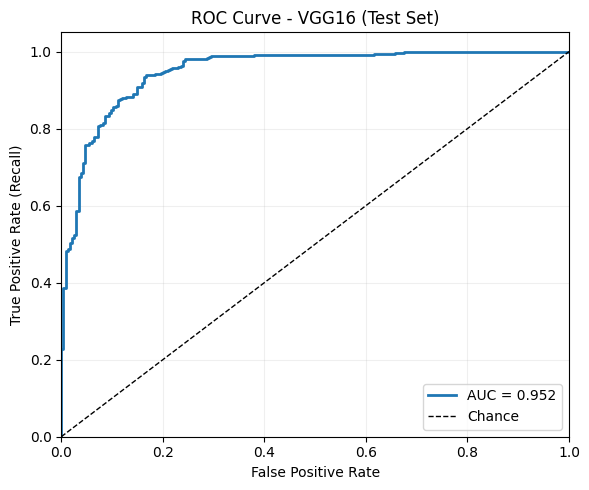

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thr = roc_curve(y_true, probs)
auc = roc_auc_score(y_true, probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='#1f77b4', lw=2)
plt.plot([0,1], [0,1], 'k--', lw=1, label='Chance')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - VGG16 (Test Set)')
plt.grid(alpha=0.2); plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


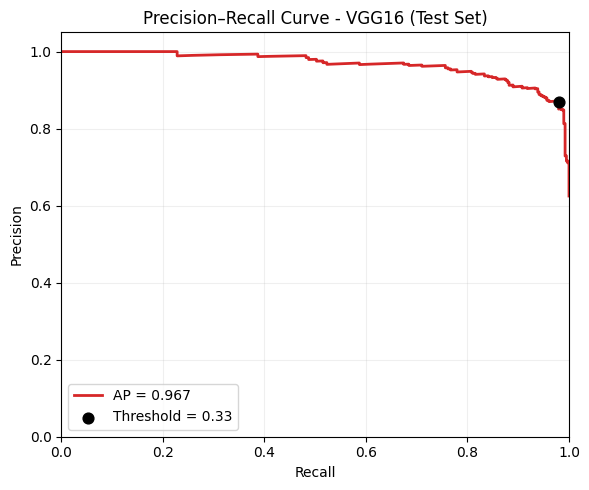

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

prec, rec, thr = precision_recall_curve(y_true, probs)
ap = average_precision_score(y_true, probs)

BEST_THR = 0.33
# find nearest threshold index (sklearn thr length = len(prec)-1)
idx = np.argmin(np.abs(thr - BEST_THR))
op_prec = prec[idx]; op_rec = rec[idx]

plt.figure(figsize=(6,5))
plt.plot(rec, prec, color='#d62728', lw=2, label=f'AP = {ap:.3f}')
plt.scatter([op_rec], [op_prec], color='black', s=60, zorder=5, label=f'Threshold = {BEST_THR:.2f}')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall Curve - VGG16 (Test Set)')
plt.grid(alpha=0.2); plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


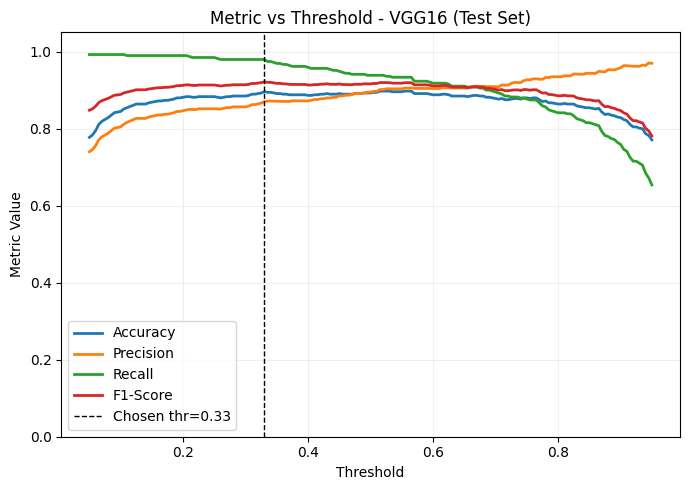

In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

ts = np.linspace(0.05, 0.95, 181)
accs, precs, recs, f1s = [], [], [], []
for t in ts:
    p = (probs > t).astype(int)
    accs.append(accuracy_score(y_true, p))
    precs.append(precision_score(y_true, p, zero_division=0))
    recs.append(recall_score(y_true, p))
    f1s.append(f1_score(y_true, p))

plt.figure(figsize=(7,5))
plt.plot(ts, accs, label='Accuracy', lw=2)
plt.plot(ts, precs, label='Precision', lw=2)
plt.plot(ts, recs, label='Recall', lw=2)
plt.plot(ts, f1s, label='F1-Score', lw=2)
plt.axvline(0.33, color='k', ls='--', lw=1, label='Chosen thr=0.33')
plt.xlabel('Threshold'); plt.ylabel('Metric Value')
plt.title('Metric vs Threshold - VGG16 (Test Set)')
plt.ylim(0,1.05); plt.grid(alpha=0.2); plt.legend()
plt.tight_layout()
plt.show()


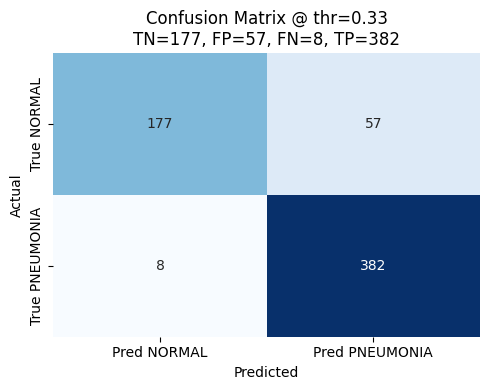

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

BEST_THR = 0.33
preds_thr = (probs > BEST_THR).astype(int)
cm = confusion_matrix(y_true, preds_thr)
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred NORMAL','Pred PNEUMONIA'],
            yticklabels=['True NORMAL','True PNEUMONIA'])
plt.title(f'Confusion Matrix @ thr={BEST_THR:.2f}\nTN={tn}, FP={fp}, FN={fn}, TP={tp}')
plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
